This example demonstrates the MUSE reconstruction, including shot-to-shot phase estimation.

Author:

* Zhengguo Tan <zhengguo.tan@gmail.com>

In [2]:
import h5py
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
import sigpy as sp
from sigpy.mri import muse, retro, sms

import torch.nn as nn
import torch.optim as optim

from deepdwi.models import mri

DIR = os.getcwd()

DAT_DIR = DIR.rsplit('/', 1)[0] + '/data'
print('> data directory: ', DAT_DIR)

# Switch on GPU if your GPU has more than 4 GB memory
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print('> device: ', device)

> data directory:  /home/zhengguo/Softwares/DeepDWI/data
> device:  cpu


### load data from Zenodo

In [3]:
files_list = ['1.2mm_32-dir_R3x2_kdat_slice_000.h5',
              '1.2mm_32-dir_R3x2_coils.h5']

for f in files_list:
    if os.path.exists('../data/' + f):
        print(f'the file {f} exists.')
    else:
        os.system('wget -P ../data/ -q https://zenodo.org/records/10531987/files/' + f)

the file 1.2mm_32-dir_R3x2_kdat_slice_000.h5 exists.
the file 1.2mm_32-dir_R3x2_coils.h5 exists.


In [3]:
f = h5py.File(DAT_DIR + '/1.2mm_32-dir_R3x2_kdat_slice_000.h5', 'r')
kdat = f['kdat'][:]
MB = f['MB'][()]
N_slices = f['Slices'][()]
N_segments = f['Segments'][()]
N_Accel_PE = f['Accel_PE'][()]
slice_idx = f['slice_idx'][()]
f.close()

kdat = np.squeeze(kdat)  # 4 dim
kdat = np.swapaxes(kdat, -2, -3)

# # split kdat into shots
N_diff = kdat.shape[-4]
kdat_prep = []
for d in range(N_diff):
    k = retro.split_shots(kdat[d, ...], shots=N_segments)
    kdat_prep.append(k)

kdat_prep = np.array(kdat_prep)
kdat_prep = kdat_prep[..., None, :, :]  # 6 dim

N_diff, N_shot, N_coil, _, N_y, N_x = kdat_prep.shape

print(' > kdat shape: ', kdat_prep.shape)


# coil
f = h5py.File(DAT_DIR + '/1.2mm_32-dir_R3x2_coils.h5', 'r')
coil = f['coil'][:]
f.close()

print(' > coil shape: ', coil.shape)

N_coil, N_z, N_y, N_x = coil.shape

 > kdat shape:  (32, 2, 32, 1, 182, 182)
 > coil shape:  (32, 94, 182, 182)


### calculate multi-band phase shift

In [4]:
yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB, yshift=yshift)

 > sms: yshift  [0.0, 0.3333333333333333]


In [5]:
slice_mb_idx = sms.map_acquire_to_ordered_slice_idx(slice_idx, N_slices, MB)

coil2 = coil[:, slice_mb_idx, :, :]

### reconstruct the 1st slice using PyTorch

In [9]:
import torchvision.transforms as T

acs_shape = list([N_y // 4, N_x //4])
ksp_acs = sp.resize(kdat_prep, oshape=list(kdat_prep.shape[:-2]) + acs_shape)

coils_tensor = sp.to_pytorch(coil2)
TR = T.Resize(tuple(acs_shape))
mps_acs_r = TR(coils_tensor[..., 0]).cpu().detach().numpy()
mps_acs_i = TR(coils_tensor[..., 1]).cpu().detach().numpy()
mps_acs = mps_acs_r + 1j * mps_acs_i

sms_phase_acs = sms.get_sms_phase_shift([MB] + acs_shape, MB=MB, yshift=yshift)

DWI_muse, dwi_shot = muse.MuseRecon(kdat_prep, coil2,
                                    MB=MB,
                                    acs_shape=acs_shape,
                                    lamda=0.01, max_iter=30,
                                    yshift=yshift,
                                    device=sp.Device(0))

_, dwi_shot_phase = muse._denoising(dwi_shot, full_img_shape=[N_y, N_x], max_iter=3)

 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
**** MUSE - ksp_acs shape  (32, 2, 32, 1, 45, 45)
**** MUSE - mps_acs shape  (32, 2, 45, 45)
>> muse on slice 00 diff 000
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
>> muse on slice 00 diff 001
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
>> muse on slice 00 diff 002
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
>> muse on slice 00 diff 003
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
>> muse on slice 00 diff 004
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
>> muse on slice 00 diff 005
 > sms: yshift  [0.

### Reconstruct one DWI at a time

In [44]:
coil_tensor = torch.from_numpy(coil2).to(device).type(torch.complex64)
kdat_tensor = torch.from_numpy(kdat_prep).to(device).type(torch.complex64)
shot_phase_tensor = torch.from_numpy(dwi_shot_phase).to(device).type(torch.complex64)
sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(torch.complex64)

DWI_jt0 = []
for n in range(3):

    print('> Diffusion Encoding #', n)

    shot_phase_n = shot_phase_tensor[[n], ...]
    kdat_prep_n = kdat_tensor[[n], ...]

    S = mri.Sense(coil_tensor, kdat_prep_n,
                  phase_echo=shot_phase_n,
                  combine_echo=True,
                  phase_slice=sms_phase_tensor)

    print('> S ishape: ', S.ishape)
    print('> S oshape: ', S.oshape)

    x = torch.zeros(S.ishape, dtype=torch.complex64,
                    device=device,
                    requires_grad=True)

    print('> x device: ', x.device)

    lossf = nn.MSELoss(reduction='sum')
    optimizer = optim.SGD([x], lr=0.6)

    for epoch in range(50):
        fwd = S(x)
        res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

        optimizer.zero_grad()
        res.backward()
        optimizer.step()

        print('> epoch %3d loss %.12f'%(epoch, res.item()))

    DWI_jt0.append(x.cpu().detach().numpy())

DWI_jt0 = np.array(DWI_jt0)

print(DWI_jt0.shape)

> Diffusion Encoding # 0
> S ishape:  [1, 1, 1, 2, 182, 182]
> S oshape:  torch.Size([1, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 0.000543790869
> epoch   1 loss 0.000176018089
> epoch   2 loss 0.000095674826
> epoch   3 loss 0.000064951717
> epoch   4 loss 0.000050485491
> epoch   5 loss 0.000042841282
> epoch   6 loss 0.000038475475
> epoch   7 loss 0.000035829940
> epoch   8 loss 0.000034146775
> epoch   9 loss 0.000033029861
> epoch  10 loss 0.000032260454
> epoch  11 loss 0.000031712225
> epoch  12 loss 0.000031309439
> epoch  13 loss 0.000031005151
> epoch  14 loss 0.000030769395
> epoch  15 loss 0.000030582538
> epoch  16 loss 0.000030431369
> epoch  17 loss 0.000030306817
> epoch  18 loss 0.000030202498
> epoch  19 loss 0.000030113850
> epoch  20 loss 0.000030037529
> epoch  21 loss 0.000029971066
> epoch  22 loss 0.000029912582
> epoch  23 loss 0.000029860650
> epoch  24 loss 0.000029814157
> epoch  25 loss 0.000029772225
> epoch  26 loss 0.000029734158
> epoch  

##### display results

(3, 182, 182)


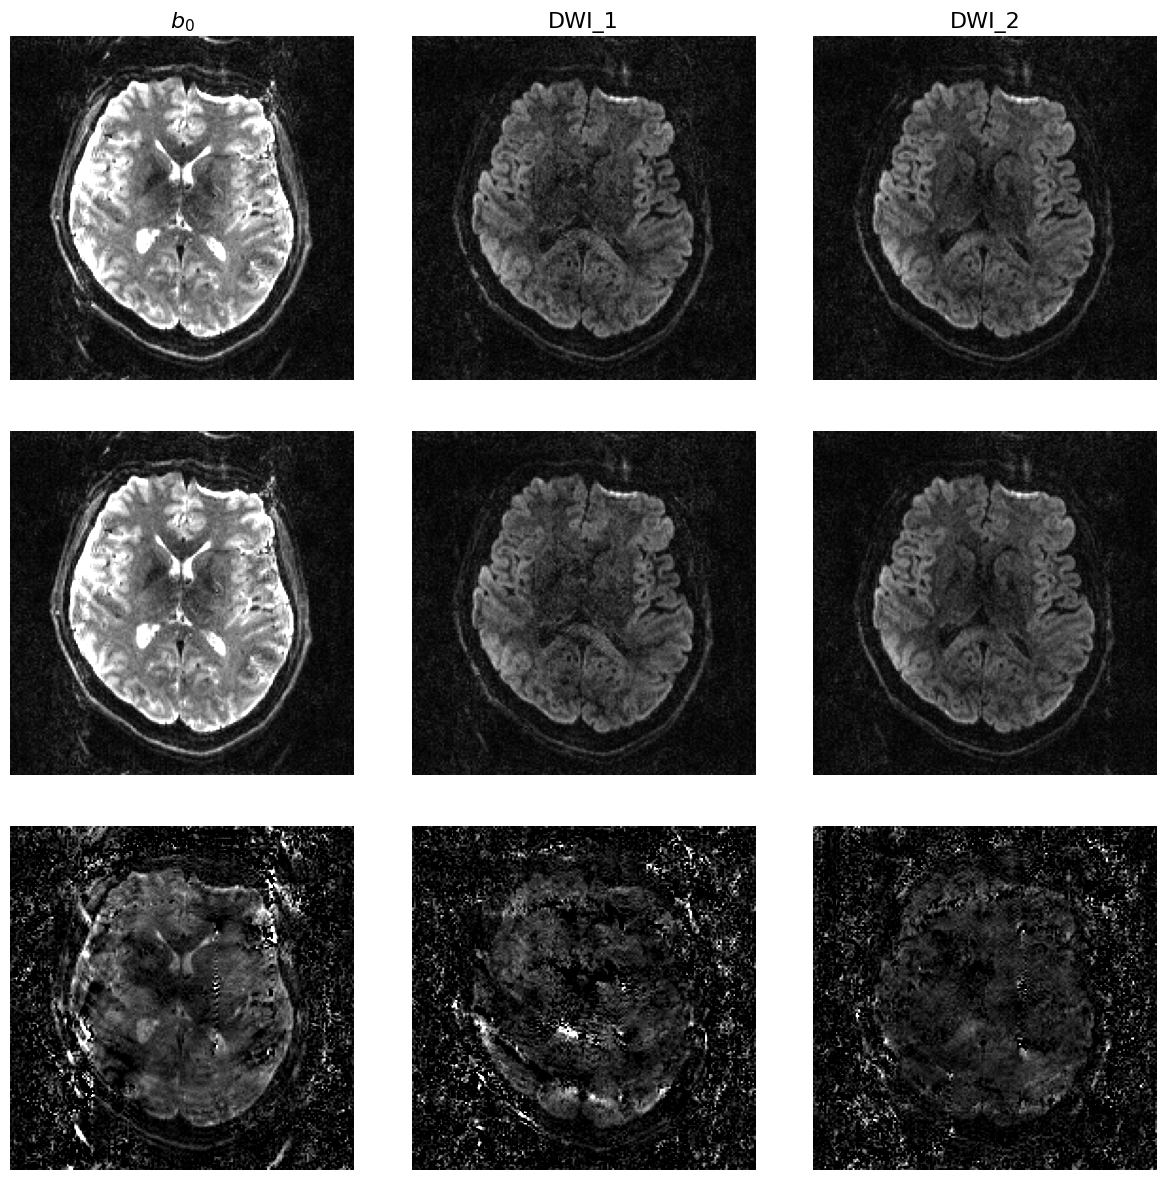

In [45]:
fontsize = 16

DWI_muse_s1 = np.squeeze(DWI_muse)
DWI_muse_s1 = DWI_muse_s1[..., 1, :, :]

DWI_jt0_s1 = np.squeeze(DWI_jt0)
DWI_jt0_s1 = DWI_jt0_s1[..., 1, :, :]

print(DWI_jt0_s1.shape)

vmax = np.amax(abs(DWI_jt0_s1)) * 0.3

fig, ax = plt.subplots(3, 3, figsize=(3*4 + 0.2, 3*4))
fig.tight_layout()

for b in range(3):
    img0 = abs(np.flip(DWI_jt0_s1[b], axis=(-2, -1)))
    ax[0][b].imshow(img0, cmap='gray', vmax=vmax)
    ax[0][b].set_axis_off()

    img1 = abs(np.flip(DWI_muse_s1[b], axis=(-2, -1)))
    ax[1][b].imshow(img1, cmap='gray', vmax=vmax)
    ax[1][b].set_axis_off()

    ax[2][b].imshow(img0 - img1, cmap='gray', vmin=0, vmax=vmax*0.1)
    ax[2][b].set_axis_off()

    if b == 0:
        ax[0][b].set_title('$b_0$', fontsize=fontsize)
    else:
        ax[0][b].set_title('DWI_' + str(b), fontsize=fontsize)

plt.show()

### Jointly reconstruct all DWIs

In [27]:
coil_tensor = torch.from_numpy(coil2).to(device).type(torch.complex64)
kdat_tensor = torch.from_numpy(kdat_prep).to(device).type(torch.complex64)
shot_phase_tensor = torch.from_numpy(dwi_shot_phase).to(device).type(torch.complex64)
sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(torch.complex64)

S = mri.Sense(coil_tensor, kdat_tensor,
              phase_echo=shot_phase_tensor,
              combine_echo=True,
              phase_slice=sms_phase_tensor)

print('> S ishape: ', S.ishape)
print('> S oshape: ', S.oshape)

x = torch.zeros(S.ishape, dtype=torch.complex64,
                device=device,
                requires_grad=True)

print('> x device: ', x.device)

lossf = nn.MSELoss(reduction='sum')
optimizer = optim.SGD([x], lr=0.3)

for epoch in range(50):
    fwd = S(x)
    res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %.12f'%(epoch, res.item()))

print('> x shape: ', x.shape)

> S ishape:  [32, 1, 1, 2, 182, 182]
> S oshape:  torch.Size([32, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 0.004759669770
> epoch   1 loss 0.002931013238
> epoch   2 loss 0.002103385050
> epoch   3 loss 0.001670115627
> epoch   4 loss 0.001418463304
> epoch   5 loss 0.001260719728
> epoch   6 loss 0.001155947801
> epoch   7 loss 0.001083132811
> epoch   8 loss 0.001030651387
> epoch   9 loss 0.000991677865
> epoch  10 loss 0.000962002203
> epoch  11 loss 0.000938919082
> epoch  12 loss 0.000920629594
> epoch  13 loss 0.000905901485
> epoch  14 loss 0.000893869728
> epoch  15 loss 0.000883913599
> epoch  16 loss 0.000875578495
> epoch  17 loss 0.000868526811
> epoch  18 loss 0.000862503191
> epoch  19 loss 0.000857312232
> epoch  20 loss 0.000852802303
> epoch  21 loss 0.000848854776
> epoch  22 loss 0.000845375587
> epoch  23 loss 0.000842289592
> epoch  24 loss 0.000839535962
> epoch  25 loss 0.000837065454
> epoch  26 loss 0.000834837556
> epoch  27 loss 0.000832818740


(32, 182, 182)


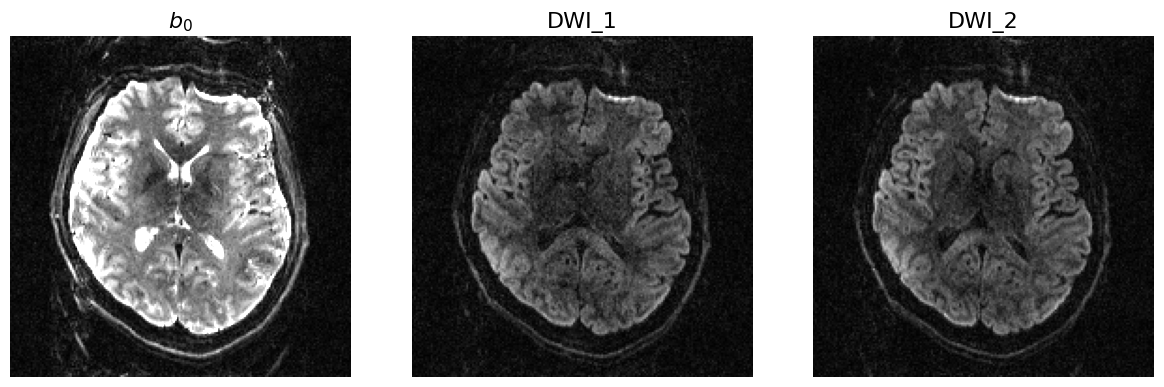

In [28]:
fontsize = 16

DWI_jt1 = x.clone().cpu().detach().numpy()

DWI_jt1_s1 = np.squeeze(DWI_jt1)
DWI_jt1_s1 = DWI_jt1_s1[..., 1, :, :]

print(DWI_jt1_s1.shape)

vmax = np.amax(abs(DWI_jt1_s1)) * 0.3

fig, ax = plt.subplots(1, 3, figsize=(3*4 + 0.2, 4))
fig.tight_layout()

for b in range(3):
    ax[b].imshow(abs(np.flip(DWI_jt1_s1[b], axis=(-2, -1))), cmap='gray', vmax=vmax)
    ax[b].set_axis_off()
    if b == 0:
        ax[b].set_title('$b_0$', fontsize=fontsize)
    else:
        ax[b].set_title('DWI_' + str(b), fontsize=fontsize)

plt.show()

### Decoder

In [12]:
import torch.nn as nn

class VAE(nn.Module):
    """
    Variational AutoEncoder
    """
    def __init__(self,
                 input_features=81,
                 latent_features=15,
                 depth=4):

        super(VAE, self).__init__()

        encoder_module = []
        decoder_module = []

        encoder_features = torch.linspace(start=input_features,
                                          end=latent_features,
                                          steps=depth+1).type(torch.int64)
        decoder_features = torch.flip(encoder_features, dims=(0, ))

        # encoder
        for d in range(depth - 1):
            encoder_module.append(nn.Linear(encoder_features[d], encoder_features[d+1]))
            encoder_module.append(nn.ReLU(True))

        self.encoder_seq = nn.Sequential(*encoder_module)

        # latent layer
        self.fc1 = nn.Linear(encoder_features[depth-1], encoder_features[depth])
        self.fc2 = nn.Linear(encoder_features[depth-1], encoder_features[depth])

        # decoder
        for d in range(depth):
            decoder_module.append(nn.Linear(decoder_features[d], decoder_features[d+1]))
            if d < (depth - 1):
                decoder_module.append(nn.ReLU(True))
            else: # last layer
                decoder_module.append(nn.Sigmoid())

        self.decoder_seq = nn.Sequential(*decoder_module)

    def encode(self, x):
        features = self.encoder_seq(x)
        return self.fc1(features), self.fc2(features)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_seq(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [13]:
import torch

model = VAE(input_features=32, latent_features=7)
model.load_state_dict(torch.load(DAT_DIR + '/train_VAE_Latent07final.pt'))
model.to(device)

temp = model.decode(torch.zeros([100, 7], device=device))
print(temp.shape)

torch.Size([100, 32])


In [14]:
print(DWI_muse.shape)

(32, 1, 2, 182, 182)


In [48]:
S = mri.Sense(coil_tensor, kdat_tensor,
              phase_echo=shot_phase_tensor,
              combine_echo=True,
              phase_slice=sms_phase_tensor,
              basis=model,
              baseline=torch.from_numpy(DWI_muse[[0]]).to(device))

print('S ishape: ', S.ishape)
print('S oshape: ', S.oshape)


latents = torch.zeros(S.ishape, dtype=torch.float32,
                      device=device,
                      requires_grad=True)

print('> x device: ', latents.device)


lossf = nn.MSELoss(reduction='sum')
optimizer = optim.Adam([latents], lr=0.1)

for epoch in range(50):
    fwd = S(latents)
    res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %.12f'%(epoch, res.item()))

S ishape:  [7, 1, 1, 2, 182, 182]
S oshape:  torch.Size([32, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 0.002409278648
> epoch   1 loss 0.002370199189
> epoch   2 loss 0.002328522038
> epoch   3 loss 0.002284421818
> epoch   4 loss 0.002240363974
> epoch   5 loss 0.002197554568
> epoch   6 loss 0.002156943548
> epoch   7 loss 0.002118611243
> epoch   8 loss 0.002082539257
> epoch   9 loss 0.002048874041
> epoch  10 loss 0.002017165767
> epoch  11 loss 0.001986708259
> epoch  12 loss 0.001957117813
> epoch  13 loss 0.001928232610
> epoch  14 loss 0.001900034142
> epoch  15 loss 0.001872515888
> epoch  16 loss 0.001845690538
> epoch  17 loss 0.001819662517
> epoch  18 loss 0.001794517040
> epoch  19 loss 0.001770374016
> epoch  20 loss 0.001747347880
> epoch  21 loss 0.001725515001
> epoch  22 loss 0.001704859780
> epoch  23 loss 0.001685356721
> epoch  24 loss 0.001666990342
> epoch  25 loss 0.001649707323
> epoch  26 loss 0.001633450389
> epoch  27 loss 0.001618165523
> epo

torch.Size([1, 1, 1, 2, 182, 182])


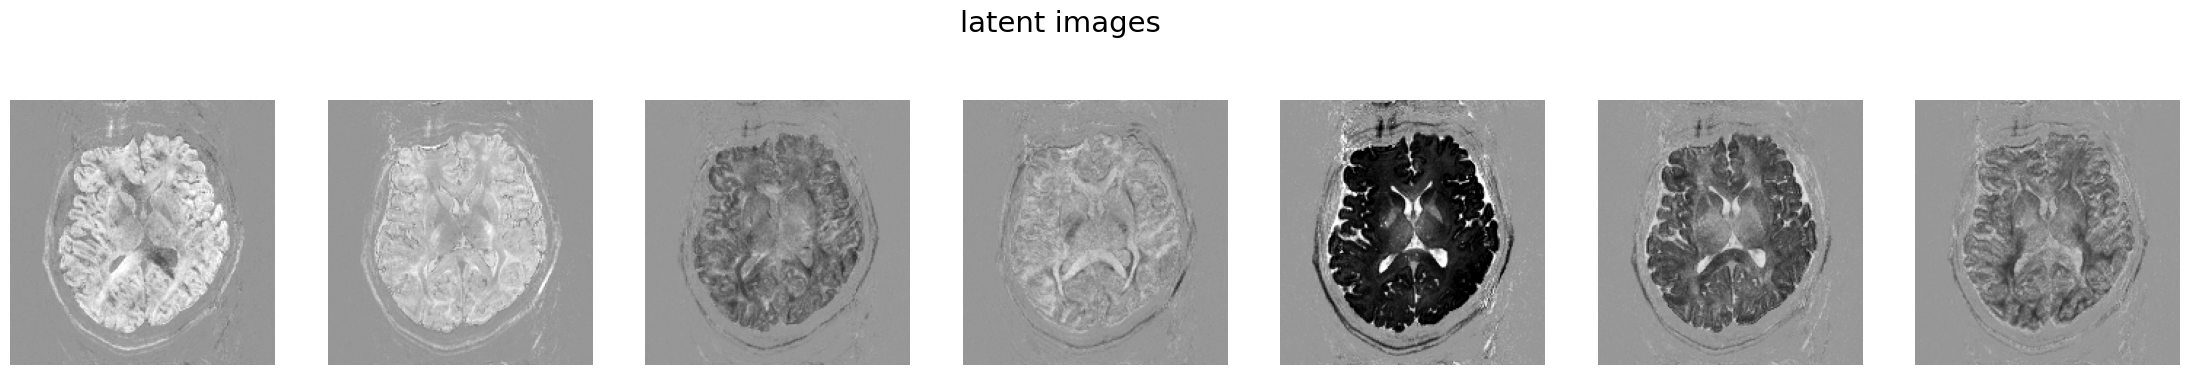

In [50]:
print(x.shape)

latents_np = latents.detach().numpy()

vmin = np.min(latents_np) * 0.8
vmax = np.max(latents_np) * 0.8

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 7, figsize=(7*4, 4.6))

for n in range(7):

    img = np.flip(latents_np[n, 0, 0, 1], axis=(-2, -1))
    img = np.fliplr(img)
    ax[n].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax[n].set_axis_off()

plt.suptitle('latent images', fontsize=21)
plt.show()